# [모듈 4.2] SageMaker Pytorch 훈련 

Download | Structure | Preprocessing (PyTorch) | **Train Model (PyTorch)** 

### [알림] <font coler="red"> conda_pytorch_p36 커널 </font> 과 함께 사용해야 합니다.

* 이 노트북은 `1.1.download_data`, `1.2.structuring_data` 및 `4.1.pytorch_preprocessing`으로 시작하는 일련의 노트북의 일부입니다.



<pre>
</pre>

# 노트북 요약
---
- SageMaker 에서 관리형 EC2 인스턴스로 훈련을 하기 위해서 "훈련 스크립트"의 주요한 내용을 확인 합니다.
- SageMaker Estimator 설정을 하고 모델 훈련을 합니다.
- 훈련된 모델의 가중치를 S3에서 다운로드 받아서 모델을 생성합니다.
- 테스트 데이터 셋트를 생성 합니다.
- 생성된 모델 및 테스트 세트를 통해서 추론을 하고 실제 예측이 잘 되었는지를 확인 합나다.


# 0. 환경 설정
___

```pytorch version:  {'1.6.0'}``` 를 확인합니다.


In [1]:
import json
import torch
import tarfile
import pickle
import matplotlib.pyplot as plt
import torchvision as tv
import pathlib  # Path management tool (standard library)
import subprocess  # Runs shell commands via Python (standard library)
import sagemaker  # SageMaker Python SDK
from sagemaker.pytorch import PyTorch  

print(f"pytorch version: ", {torch.__version__})

pytorch version:  {'1.6.0'}


### 카테고리 레이블, 버킷 이름 및 훈련/검증 데이터 셋 로딩


In [2]:
with open("pickled_data/category_labels.pickle", "rb") as f:
    category_labels = pickle.load(f)


In [3]:
%store -r bucket_name
%store -r train_pytorch_s3_uri
%store -r val_pytorch_s3_uri

<pre>
</pre>

# 1. 훈련 스크립트 리뷰
___

### 훈련 함수
- 다른 프레임워크와 달리 PyTorch는 `.fit()` 메서드가 있는 모델 객체를 사용하여 훈련하지 않습니다. 
- 대신 사용자는 자신의 훈련 기능을 정의해야 합니다. 이렇게 하면 훈련 스크립트에 더 많은 코드가 추가되지만 모델 훈련을 사용자 지정하고 디버깅하는 데 더 많은 투명성을 제공합니다. 
- 이것이 연구자들이 PyTorch를 즐겨 사용하는 주요 이유 중 하나입니다. 이 예제에서는 PyTorch 자습서에 정의된 훈련 기능을 사용하여 여기에서 전이 학습을 수행합니다. 

In [4]:
!pygmentize "training_pytorch/pytorch_train.py" | sed -n 15,78p


def train(model, criterion, optimizer, scheduler, epochs=1):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(epochs):
        print("Epoch {}/{}".format(epoch, epochs - 1))
        print("-" * 10)

        # Each epoch has a training and validation phase
        for phase in ["train", "val"]:
            if phase == "train":
                model.train()  # Set model to training mode
            else:
                model.eval()  # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == "train

### 훈련 스크립트 메인 함수
훈련 스크립트는 if 문에서 훈련 코드를 래핑합니다.

In [5]:
!pygmentize "training_pytorch/pytorch_train.py" | sed -n 83p

if __name__ == "__main__":


### 입력 파라미터 분석
이러한 입력 파라미터는 하이퍼파라미터 인수와 fit 메소드에 대한 입력 인수를 통해 전달됩니다.

In [6]:
!pygmentize "training_pytorch/pytorch_train.py" | sed -n 82,91p


if __name__ == "__main__":

    parser = argparse.ArgumentParser()

    parser.add_argument("--epochs", type=int, default=50)
    parser.add_argument("--batch-size", type=int, default=4)
    parser.add_argument("--learning-rate", type=float, default=0.001)
    parser.add_argument("--workers", type=int, default=0)



### 데이터 변환 정의 및 데이터 로드
- 이것은 전처리 가이드의 변형입니다. 데이터가 S3에 저장되기 전에 크기가 조정되었습니다.
- 그래서 훈련 데이터 세트의 무작위 자르기와 검증 데이터 세트 중앙 자르기를 제외하고는 크기 조정을 수행할 필요가 없습니다.

In [7]:
!pygmentize "training_pytorch/pytorch_train.py" | sed -n 96,120p

    # define transformations
    data_transforms = {
        "train": tv.transforms.Compose(
            [
                tv.transforms.RandomResizedCrop(224),
                tv.transforms.RandomHorizontalFlip(p=0.5),
                tv.transforms.RandomVerticalFlip(p=0.5),
                tv.transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
                tv.transforms.ToTensor(),
            ]
        ),
        "val": tv.transforms.Compose([tv.transforms.CenterCrop(224), tv.transforms.ToTensor()]),
    }

    # create datasets and dataloaders
    splits = ["train", "val"]
    datasets = {}
    for s in splits:
        datasets[s] = tv.datasets.ImageFolder(root=data_dir / s, transform=data_transforms[s])

    dataloaders = {}
    for s in splits:
        dataloaders[s] = torch.utils.data.DataLoader(
            datasets[s], batch_size=args.batch_size, shuffle=True, num_workers=args.workers
        )


### 장치 감지 및 기본 모델 생성 및 수정
이 가이드의 기본 모델은 사전 훈련된 가중치를 사용하는 RestNet18 모델입니다. 동물 이미지를 분류하기 위해 완전 연결 레이어를 밀집 레이어로 교체하여 기본 모델을 수정해야 합니다. 그런 다음 EC@ 인스턴스가 사용하는 장치(GPU 또는 CPU)에 대한 모델이 로드됩니다.

In [8]:
!pygmentize "training_pytorch/pytorch_train.py" | sed -n 124,131p

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(f"Training with: {device}")

    model = tv.models.resnet18(pretrained=True)
    num_ftrs = model.fc.in_features
    model.fc = torch.nn.Linear(num_ftrs, num_classes)
    model = model.to(device)



### 손실 기준, 최적화 알고리즘 정의 및 모델 학습
최고의 정확도를 가진 에포크의 가중치가 저장되므로 훈련 후 모델을 로드하고 테스트 데이터에 대해 예측할 수 있습니다.

In [9]:
!pygmentize "training_pytorch/pytorch_train.py" | sed -n 132,138p

    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=args.learning_rate, momentum=0.9)
    exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
    model = train(model, criterion, optimizer, exp_lr_scheduler, epochs=args.epochs)

    torch.save(model.state_dict(), "/opt/ml/model/model.pt")


# 2. SageMaker Estimator 설정 
___

교육에 사용할 리소스와 리소스 구성 방법을 정의합니다. 상세 사항은 아래를 참조 하세요.

- [Pytorch Estimator](https://sagemaker.readthedocs.io/en/stable/frameworks/pytorch/sagemaker.pytorch.html)


<a id='idg4b.2'></a>
### 알고리즘 하이퍼파라미터
___
- 하이퍼파라미터는 훈련이 시작되기 전에 설정한 알고리즘의 튜닝 파라미터를 나타냅니다. 일반적으로 기본값으로 미리 설정되어 있으므로 지정하지 않으면 훈련 알고리즘을 계속 실행할 수 있지만 일반적으로 최적의 결과를 얻으려면 조정이 필요합니다. 이러한 값이 무엇인지는 전적으로 데이터 세트에 따라 다릅니다. 
- 불행히도 최고의 설정이 무엇인지 알려주는 공식은 없습니다. 직접 시도하고 결과를 확인해야 하지만 선택하는 데 도움이 되는 모범 사례와 팁이 있습니다.

* **학습률** - 교육의 각 배치 후에 우리는 해당 배치에 대해 가능한 최상의 결과를 제공하기 위해 모델의 가중치를 업데이트합니다. 학습률은 가중치를 업데이트해야 하는 정도를 제어합니다. 모범 사례는 0.2에서 .001 사이의 값을 지정하며 일반적으로 1보다 높지 않습니다. 학습률이 높을수록 훈련이 최적의 가중치로 더 빨리 수렴되지만 너무 빠르면 목표를 초과할 수 있습니다. 이 예에서는 사전 훈련된 모델의 가중치를 사용하므로 가중치가 이미 최적화되어 있고 가중치에서 너무 멀리 이동하고 싶지 않기 때문에 더 낮은 학습률로 시작하려고 합니다.

* **에포크** - 에포크는 훈련 세트의 한 주기를 나타내며 훈련할 에포크가 많다는 것은 정확도를 향상시킬 기회가 더 많다는 것을 의미합니다. 적절한 값은 시간과 예산 제약에 따라 5~25 Epoch 범위입니다. 이상적으로는 검증 정확도가 안정되기 직전에 값이 올바른 Epoch 수 입니다.

* **Batch Size** - 일괄 학습은 RAM에 보관해야 하는 데이터의 양을 줄이고 학습 알고리즘의 속도를 높일 수 있습니다. 이러한 이유로 훈련 데이터는 거의 항상 일괄 처리됩니다. 최적의 배치 크기는 데이터 세트, 이미지 크기 및 훈련 컴퓨터의 RAM 용량에 따라 다릅니다. 우리와 같은 데이터 세트의 경우 합리적인 값은 배치당 18개에서 64개 이미지입니다.



In [10]:
hyperparameters = {"epochs": 10, "batch-size": 64, "learning-rate": 0.001, 
                   "workers": 4}
instance_type = 'ml.p3.2xlarge'
data_channels = {"train": train_pytorch_s3_uri, "val": val_pytorch_s3_uri}



#### 참고:  workers 세팅 실험
- workers : 0 설정시 총 훈련 시간은 270 초
    
```
hyperparameters = {"epochs": 5, "batch-size": 64, "learning-rate": 0.001, 
                   "workers": 0}
instance_type = 'ml.p3.2xlarge'
```

- workers : 4 설정시 총 훈련 시간은 181 초
    
```
hyperparameters = {"epochs": 5, "batch-size": 64, "learning-rate": 0.001, 
                   "workers": 4}
instance_type = 'ml.p3.2xlarge'
```


In [11]:
from sagemaker.pytorch import PyTorch
import os
import subprocess


pytorch_estimator = PyTorch(
    entry_point="pytorch_train.py",    
    source_dir='training_pytorch',    
    role=sagemaker.get_execution_role(),
    framework_version='1.6.0',
    py_version='py3',
    instance_count=1,
    instance_type=instance_type, # local_gpu or local 지정
    session = sagemaker.Session(),
    hyperparameters=hyperparameters,                   
    
)


# 3. 모델 훈련
- 총 소요시간이 약 5분 걸립니다.

In [12]:
pytorch_estimator.fit(data_channels)

2021-12-28 10:25:21 Starting - Starting the training job...
2021-12-28 10:25:45 Starting - Launching requested ML instancesProfilerReport-1640687117: InProgress
......
2021-12-28 10:26:45 Starting - Preparing the instances for training.........
2021-12-28 10:28:06 Downloading - Downloading input data...
2021-12-28 10:28:46 Training - Downloading the training image......
2021-12-28 10:29:53 Training - Training image download completed. Training in progress..bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2021-12-28 10:29:53,913 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2021-12-28 10:29:53,936 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2021-12-28 10:29:54,553 sagemaker_pytorch_container.training INFO     Invoking user training script.
2021-12-28 10:29:56,059 sagemaker-training-toolkit INFO     Invoking user script
Training Env:
{
 

# 4. 훈련된 모델 로드 및 테스트 데이터 로딩
___

- 모델 가중치는 S3에 저장이 되고, 다운로드 후에 모델에 가중치를 다시 로드하여 예측을 생성할 수 있습니다. 
- 훈련 후에 테스트 데이터에서 모델을 평가하는 것이 중요합니다. 

### S3에서 훈련된 모델 다운로드 및 압축 해제

In [13]:
sagemaker.s3.S3Downloader().download(pytorch_estimator.model_data, "training_pytorch")
tf = tarfile.open("training_pytorch/model.tar.gz")
tf.extractall("training_pytorch")

### 가중치를 PyTorch 모델에 다시 로드
모델이 GPU에서 훈련되었기 때문에 CPU 지원 노트북 인스턴스에서 모델을 로드하려면 `map_location=torch.device('cpu')` kwarg를 사용해야 합니다.

In [14]:
try:
    model = tv.models.resnet18()
    num_ftrs = model.fc.in_features
    model.fc = torch.nn.Linear(num_ftrs, 11)
    model.load_state_dict(torch.load("training_pytorch/model.pt", map_location=torch.device("cpu")))
    model.eval()
except Exception:
    import traceback
    traceback.print_exc()   

    

#### 모델 예측(0에서 9까지)을 원래 클래스 이름(곰에서 얼룩말까지)에 다시 연결

In [15]:
category_labels = {idx: name for idx, name in enumerate(sorted(category_labels.values()))}
category_labels

{0: 'bear',
 1: 'bird',
 2: 'cat',
 3: 'cow',
 4: 'dog',
 5: 'elephant',
 6: 'frog',
 7: 'giraffe',
 8: 'horse',
 9: 'sheep',
 10: 'zebra'}

### 예측을 위해 테스트 데이터 세트에서 이미지 로드

In [16]:
test_ds = sample = tv.datasets.ImageFolder(
    root="data_resized/test",
    transform=tv.transforms.Compose([tv.transforms.CenterCrop(244), tv.transforms.ToTensor()]),
)

test_ds = torch.utils.data.DataLoader(test_ds, batch_size=4, shuffle=True)

# 5.모델 추론과 함께 검증 이미지 표시
더 많은 예측을 보려면 셀을 다시 실행하세요.

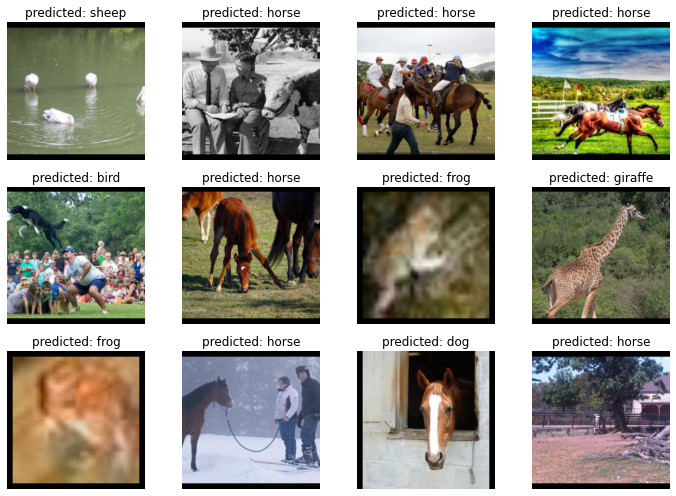

In [17]:
rows = 3
cols = 4
fig, axs = plt.subplots(rows, cols, figsize=(10, 7))

for row in range(rows):
    batch = next(iter(test_ds))
    images, labels = batch
    _, preds = torch.max(model(images), 1)
    preds = preds.numpy()
    for col, image in enumerate(images):
        ax = axs[row, col]
        ax.imshow(image.permute(1, 2, 0))
        ax.axis("off")
        ax.set_title(f"predicted: {category_labels[preds[col]]}")

plt.tight_layout()

<pre>
</pre>

## 다음 단계

- 이것으로 SageMaker의 TensorFlow 프레임워크에 대한 이미지 데이터 가이드를 마칩니다. 
- 모델을 배포하고 테스트 데이터에 대한 예측을 얻으려면 진행에 필요한 모든 정보를 여기에서 찾을 수 있습니다. 

- [추론을 위한 모델배포](https://docs.aws.amazon.com/sagemaker/latest/dg/deploy-model.html)
